# Giới thiệu về Gamlss


Sau khi học R khoảng 1 năm và quen thuộc với hồi quy tuyến tính và mixed Model thì Nhi quyết định khám phá package Gamlss và nhận ra đây không phải là 1 package dễ học. Nhiều lần Nhi phải ngừng bước vì cấu trúc phức tạp bên trong gamlss và mãi đến năm 2016 mới luyện xong package này (mất 3 năm).

Có thể nói Gamlss là "võ lâm chí tôn" cho phái hồi quy. Nó là 1 framework phức tạp và tổng quát nhất cho mô hình hồi quy, với khả năng vô cùng mạnh mẽ và tinh tế như sau :

Gamlss hỗ trợ hơn 100 họ phân phối khác nhau, và hơn thế nữa, nó cho phép bạn tạo ra kiểu phân phối cho riêng mình do đó nó có khả năng biểu diễn tất cả quy luật phân phối nào dù kì dị đến đâu.

Gamlss cho phép mô hình hóa tất cả (từ 2-4) tham số của 1 họ phân phối bao gồm mô hình cho Mean (Mu, vị trí), Sigma (Scale), Tau và Nu (kiểu hình, shape). Thí dụ với phân phối Gaussian, bạn có thể dựng 1 mô hình cho Mean và 1 mô hình cho Sigma, với link function tùy chọn. Ngoài ra gamlss còn cho phép làm quantile regression.

Gamlss hỗ trợ tất cả các dạng Additive terms, bao gồm Smoothing với Penalized spline, P-splines, Cubic splines, Ridge và Lasso, GMRF, tensor product splines, thin plate splines; Loess spline, neural network, decision tree và MARS. Như vậy từ mô hình tuyến tính, bạn có thể biến hóa thành đủ loại mô hình phi tuyến tính, kết hợp hồi quy tuyến tính (cho linear terms) với Kernel, neural network và decision tree (cho smoothing term)

Gamlss cho phép dựng mô hình với Random Effects

Gamlss có cả tính năng Machine learning với K fold Cross-validation, bootstrap, Training và validation

# Một thí dụ minh họa

Chúng ta sẽ sử dụng dataset về nồng độ glycosaminoglycans (GAG) ở trẻ em từ sơ sinh đến 18 tuổi. Dataset này có 314 quan sát. Mục tiêu của chúng ta là dựng một mô hình để khảo sát giá trị GAG theo tuổi.

Thăm dò số liệu cho ta thấy quan hệ giữa GAG và Age không thể nào được mô tả bằng một mô hình tuyến tính, ngoài ra phương sai của GAG cũng không đồng nhất giữa các phân nhóm tuổi

In [19]:
df=read.csv("http://vincentarelbundock.github.io/Rdatasets/csv/MASS/GAGurine.csv")

age.cat <- function(x, lower = 0, upper, by = 10,
                    sep = "-", above.char = "+") {
  
  labs <- c(paste(seq(lower, upper - by, by = by),
                  seq(lower + by - 1, upper - 1, by = by),
                  sep = sep),
            paste(upper, above.char, sep = ""))
  
  cut(floor(x), breaks = c(seq(lower, upper, by = by), Inf),
      right = FALSE, labels = labs)
}


df$range=age.cat(x=df$Age,upper=17,by=2)

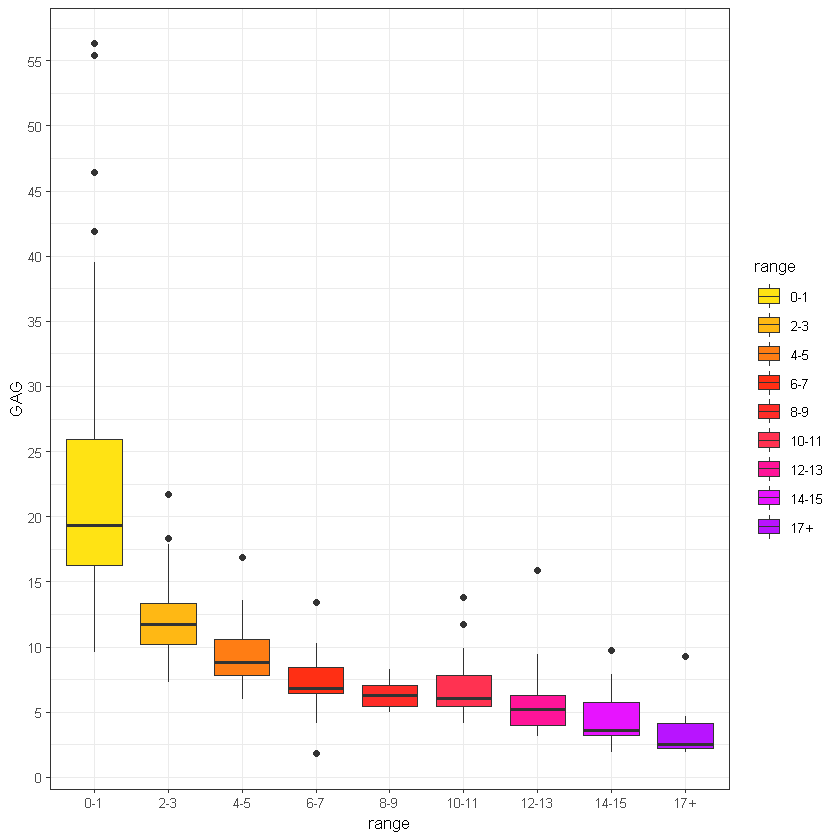

In [20]:
library(tidyverse)

mycolors=c("#ffe314","#ffb814","#ff7d14","#ff2f14","#ff2c28","#ff3251","#ff1499","#e714ff","#b814ff")


df%>%ggplot(aes(x=range,y=GAG))+geom_boxplot(aes(fill=range))+
  scale_fill_manual(values=mycolors)+
  theme_bw(10)+
  scale_y_continuous(breaks=c(0,5,10,15,20,25,30,35,40,45,50,55))

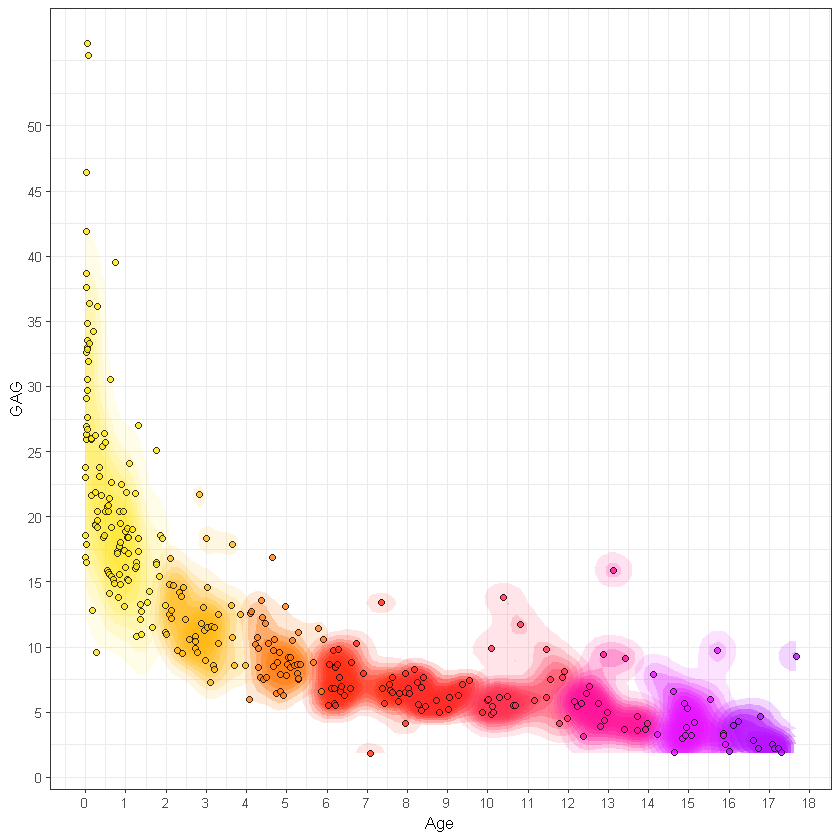

In [21]:
df%>%ggplot(aes(x=Age,y=GAG))+
  stat_density2d(geom="polygon",aes(fill=df$range,alpha = ..level..),show.legend = F)+
  scale_fill_manual(values=mycolors)+
  geom_point(shape=21,color="black",aes(fill=df$range),alpha=0.8,show.legend = F)+
  theme_bw(10)+
  scale_x_continuous(breaks=c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))+
  scale_y_continuous(breaks=c(0,5,10,15,20,25,30,35,40,45,50))

# So sánh Cú pháp Gamlss với hàm lm() và glm()

Đầu tiên, chúng ta sẽ làm quen với gamlss bằng 1 mô hình hồi quy tuyến tính đơn biến hết sức đơn giản, và như ta thấy, cú pháp gamlss hoàn toàn tương đồng với những hàm lm() và glm() trong base R. Nội dung mô hình (hệ số hồi quy) có thể xem như tương đương, tuy nhiên như đã đề cập, Gamlss cung cấp 2 mô hình cho cả Mu và Sigma thay vì chỉ dự báo Mu ; do đó độ tự do chỉ còn 311, vì 1 df đã được dùng để tính sigma như 1 hằng số)

In [22]:
l1=lm(data=df,GAG~Age)
summary(l1)


Call:
lm(formula = GAG ~ Age, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-9.950 -4.217 -1.596  2.477 36.470 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19.89381    0.52553   37.85   <2e-16 ***
Age         -1.27253    0.07242  -17.57   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.386 on 312 degrees of freedom
Multiple R-squared:  0.4974,	Adjusted R-squared:  0.4958 
F-statistic: 308.7 on 1 and 312 DF,  p-value: < 2.2e-16


In [23]:
library(gamlss)

g1=gamlss(data=df,formula=GAG~Age,family=NO,trace=FALSE)

summary(g1)

Warning message:
"package 'gamlss' was built under R version 3.6.1"Loading required package: splines
Loading required package: gamlss.data

Attaching package: 'gamlss.data'

The following object is masked from 'package:datasets':

    sleep

Loading required package: gamlss.dist
Warning message:
"package 'gamlss.dist' was built under R version 3.6.1"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: nlme

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

Loading required package: parallel
 **********   GAMLSS Version 5.1-4  ********** 
For more on GAMLSS look at http://www.gamlss.org/
Type gamlssNews() to see new features/changes/bug fixes.



******************************************************************
Family:  c("NO", "Normal") 

Call:  gamlss(formula = GAG ~ Age, family = NO, data = df,      trace = FALSE) 


Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19.89381    0.52385   37.98   <2e-16 ***
Age         -1.27253    0.07219  -17.63   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.8509     0.0399   46.38   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
No. of observations in the fit:  314 
Degrees of Freedom for the fit:  3
      Residual Deg. of Freedom:  

In [24]:
confint(g1)

,2.5 %,97.5 %
(Intercept),18.867081,20.920533
Age,-1.414018,-1.131032


Ta có thể tính Rsq, CI95% cho hệ số hồi quy và vẽ 1 số đồ thị để kiểm tra các giả định về phẩm chất mô hình. Như đã dự tính, mô hình tuyến tính cho ra kết quả rất tồi.

In [25]:
Rsq(g1,type="both")

$CoxSnell
[1] 0.4973689

$CraggUhler
[1] 0.4977304

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  9.03885e-13 
                       variance   =  1.003195 
               coef. of skewness  =  2.093835 
               coef. of kurtosis  =  10.03964 
Filliben correlation coefficient  =  0.9140833 
******************************************************************


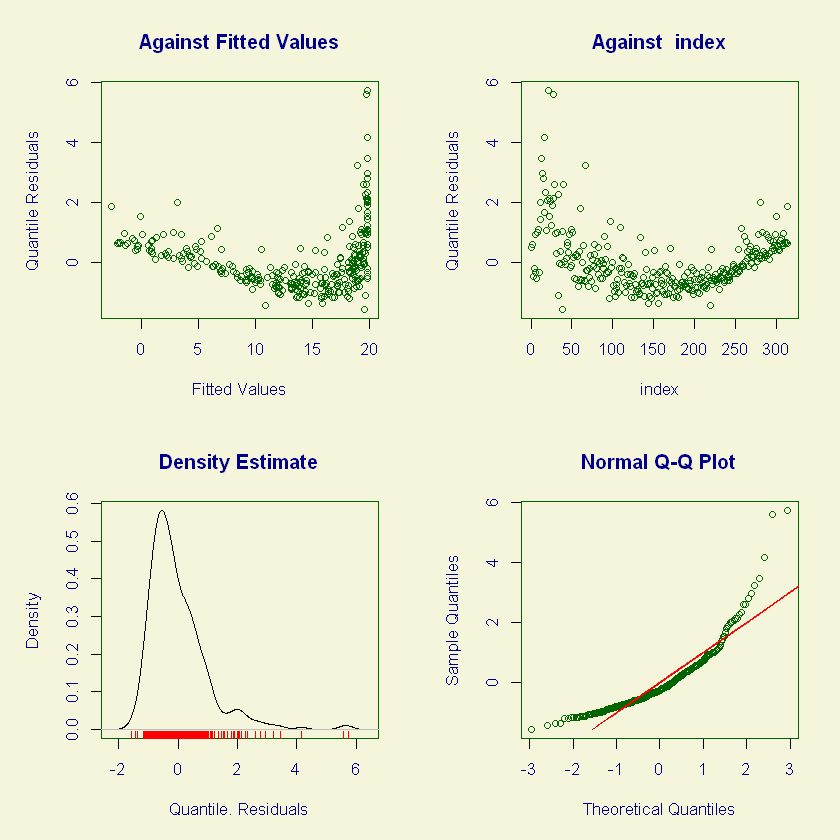

In [26]:
plot(g1)

# Hàm gamlss với các họ phân phối Gamma và Box-Cox Cole Green

Các bạn đã quen với cú pháp hàm gamlss rồi, bây giờ ta chơi 1 trò chơi nhỏ, đó là lần lượt thử 2 họ phân phối khác nhau là Gamma và Box Cox Cole Green.

Các bạn có thể nhận ra là với những họ phân phối phức tạp hơn, Gamlss bắt đầu dựng mô hình cho nhiều tham số hơn, thí dụ Sigma, Tau và Nu ; bạn có thể đặt formula cho từng tham số tùy thích. Đây là thứ mà glm() không thể làm được.

In [27]:
g6=gamlss(GAG~poly(Age,3)+pb(Age),sigma.fo=~poly(Age,2)+pb(Age),family=GA,data=df,method=RS(1000))

Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in r

GAMLSS-RS iteration 1: Global Deviance = 1597.256 


Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"

GAMLSS-RS iteration 2: Global Deviance = 1597.094 


Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"

GAMLSS-RS iteration 3: Global Deviance = 1597.094 


In [28]:
summary(g6)

******************************************************************
Family:  c("GA", "Gamma") 

Call:  
gamlss(formula = GAG ~ poly(Age, 3) + pb(Age), sigma.formula = ~poly(Age,  
    2) + pb(Age), family = GA, data = df, method = RS(1000)) 

Fitting method: RS(1000) 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.41000    0.01702 141.630  < 2e-16 ***
poly(Age, 3)1 -9.70609    0.40250 -24.115  < 2e-16 ***
poly(Age, 3)2  2.82411    0.37473   7.536 5.47e-13 ***
poly(Age, 3)3 -2.16491    0.33848  -6.396 5.94e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.25573    0.03932 -31.936  < 2e-16 ***
poly(Age, 2)1  2.56608    0.69098   3.714 0.000243 ***
pol

number of missing points from plot= 0  out of  78 
number of missing points from plot= 0  out of  79 
number of missing points from plot= 1  out of  79 


Warning message in panel(x[id], y[id], col = col[id], pch = pch[id], ...):
"Some points are missed out 
increase the y limits using ylim.worm"

number of missing points from plot= 0  out of  78 


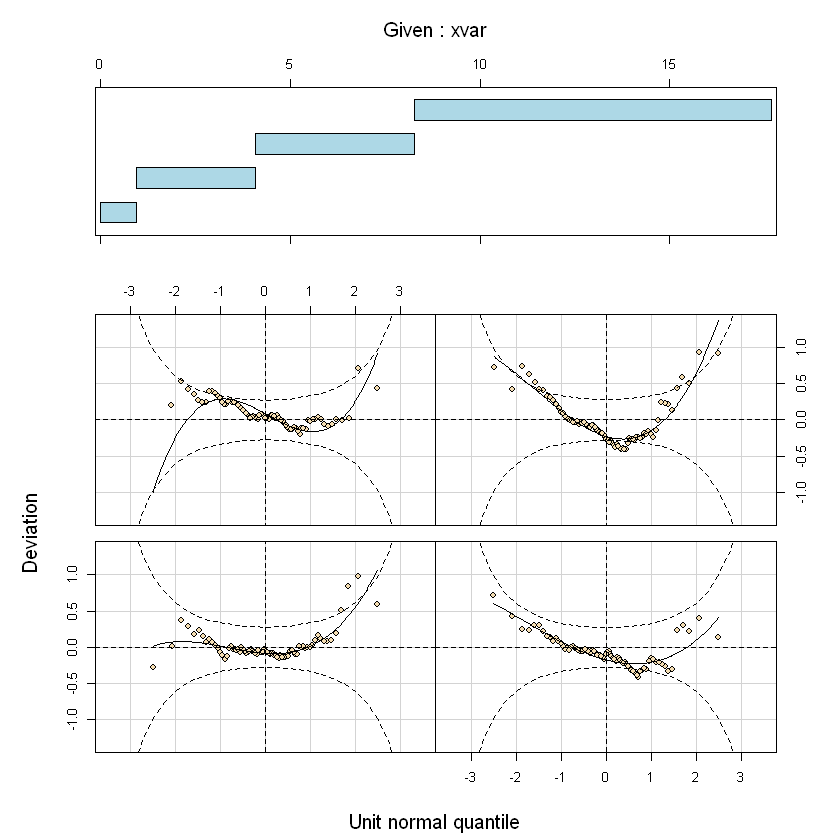

In [29]:
wp(object=g6,xvar=df$Age)

In [32]:
g2=gamlss(data=df,formula=GAG~Age,family=GA,trace=FALSE)

g5=gamlss(GAG~pb(Age),sigma.fo=~Age,nu.fo=~Age,family=BCCG,data=df,method=RS(1000),trace =FALSE)

Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in r

"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to uniqu

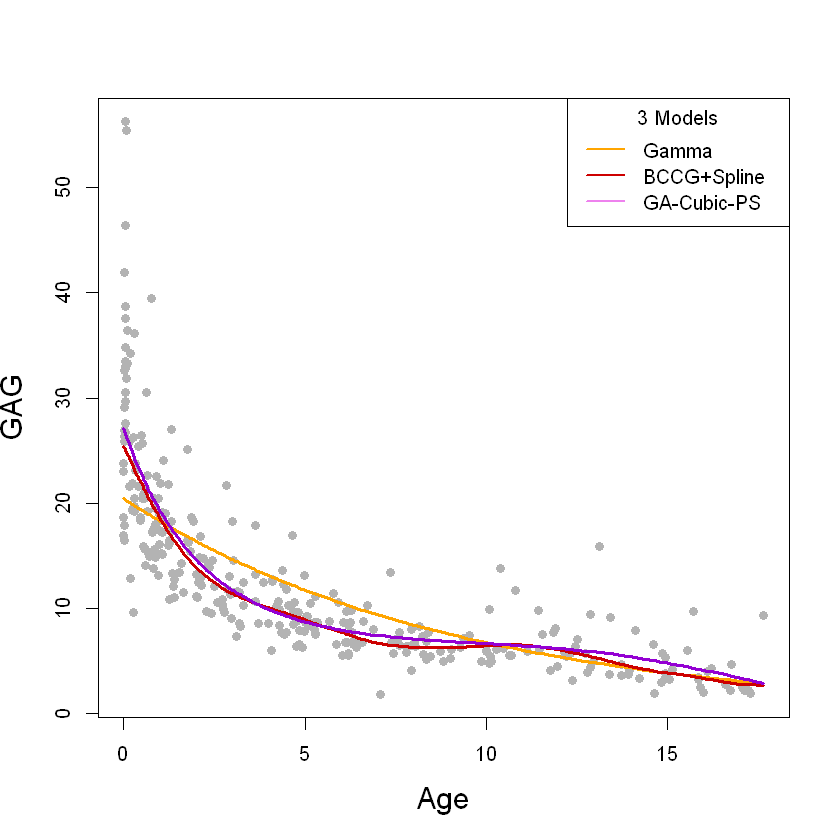

In [33]:
plot(GAG~ Age, data = df, cex.lab=1.5,pch=16,col=grey(0.7))
lines(df$Age[order(df$Age)], fitted(g2)[order(df$Age)],
      lty=1, lwd=2.5, col = "orange")

lines(df$Age[order(df$Age)], fitted(g5)[order(df$Age)],
      lty=1, lwd=2.5, col = "red3")

lines(df$Age[order(df$Age)], fitted(g6)[order(df$Age)],
      lty=1, lwd=2.5, col = "darkviolet")

legend("topright",legend=c("Gamma","BCCG+Spline","GA-Cubic-PS"),
       col=c("orange","red3","violet"), lwd=2, title="3 Models")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


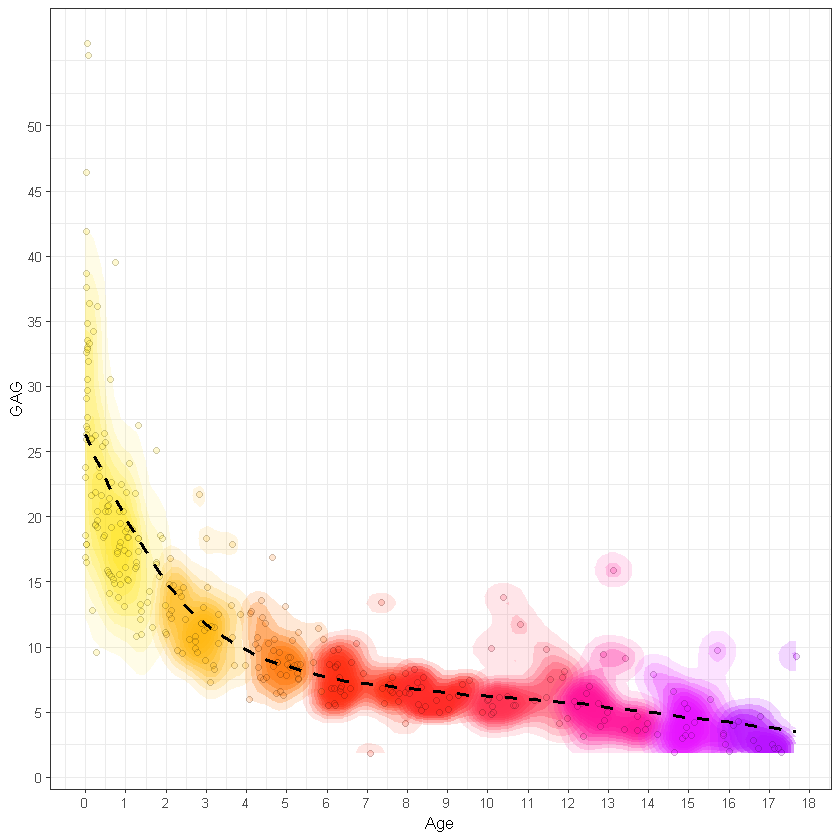

In [46]:
df=df%>%mutate(.,predict=predict(g6,type="response"))

df%>%ggplot()+
  stat_density2d(geom="polygon",aes(x=Age,y=GAG,fill=df$range,alpha = ..level..),show.legend = F)+
  scale_fill_manual(values=mycolors)+
  geom_point(shape=21,color="black",aes(x=Age,y=GAG,fill=df$range),alpha=0.2,show.legend = F)+
  geom_smooth(aes(x=Age,y=predict),se=F,color="black",linetype=2,show.legend = F)+
  theme_bw(10)+
  scale_x_continuous(breaks=c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))+
  scale_y_continuous(breaks=c(0,5,10,15,20,25,30,35,40,45,50))

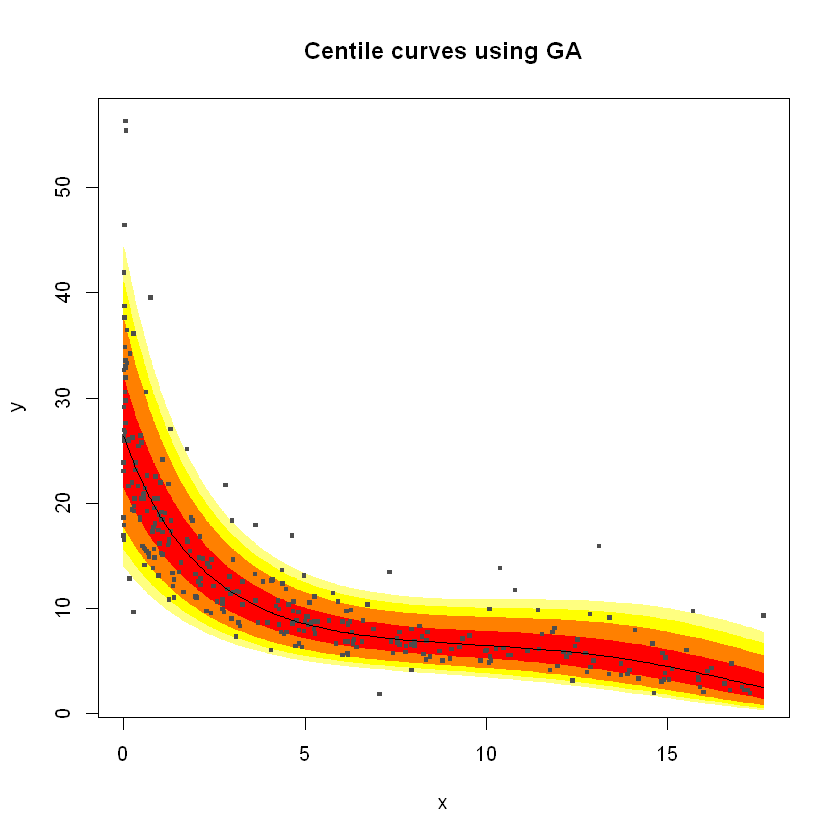

In [36]:
centiles.fan(g6, xvar=df$Age, cent=c(2.5,5,10,25,50,75,90,95,97.5),colors = "heat",points=T,col=gray(0.3))

Warning message:
"package 'gamlss.util' was built under R version 3.6.1"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'viridisLite' was built under R version 3.6.1"Warning message in predict.gamlss(object, newdata = newdata, what = "mu", type = type, :
"There is a discrepancy  between the original and the re-fit 
 used to achieve 'safe' predictions 
 "

new prediction 
New way of prediction in pb()  (starting from GAMLSS version 5.0-3) 


Warning message in predict.gamlss(object, newdata = newdata, data = DatA, what = "sigma", :
"There is a discrepancy  between the original and the re-fit 
 used to achieve 'safe' predictions 
 "

new prediction 
New way of prediction in pb()  (starting from GAMLSS version 5.0-3) 


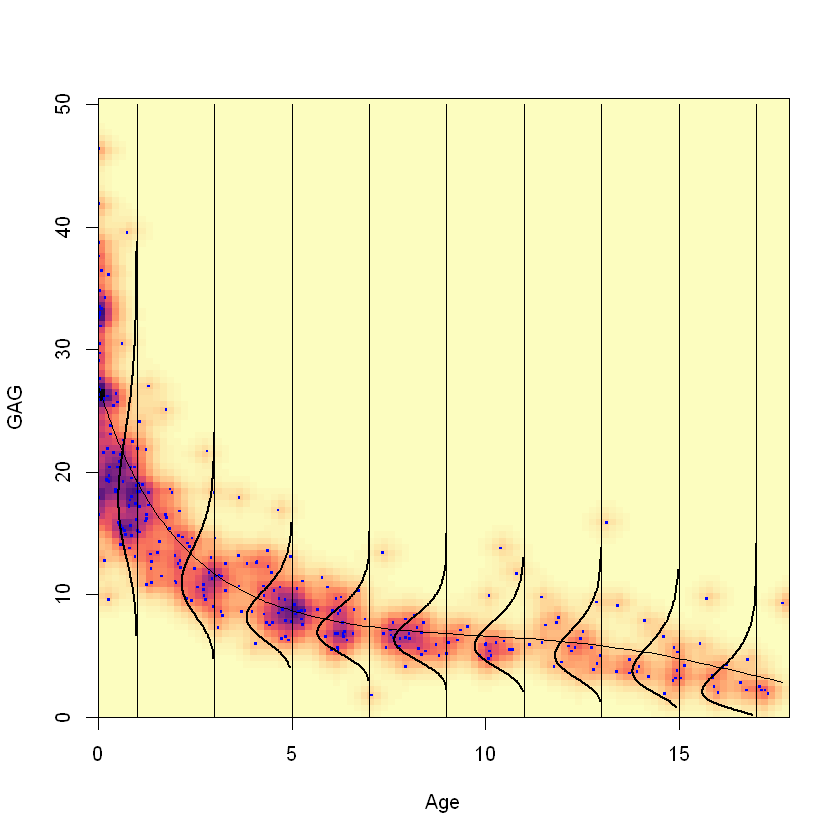

In [44]:
library(gamlss.util)
library(viridisLite)

plotSimpleGamlss(GAG,Age,model=g6, data=df,cols=viridis(option="A",n=100),x.val=seq(1,18,2),val=6,N=500,ylim=c(0,50))

In [ ]:
install.packages('viridisLite')

Trong bài này Nhi chỉ muốn minh họa với các bạn cách sử dụng R trong jupyter.

Xin cảm ơn và hẹn gặp lại.